# Flower classification

## Import necessary libraries


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

SEED = 12
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 1s 0us/step


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"Total image count: {image_count}")

Total image count: 3670


Here are some roses:

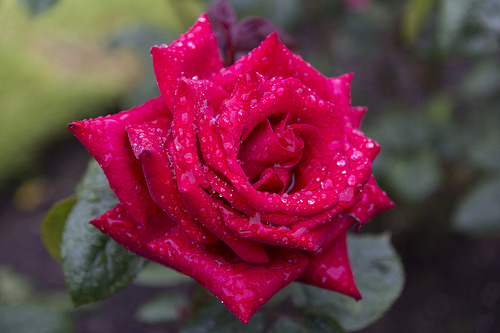

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

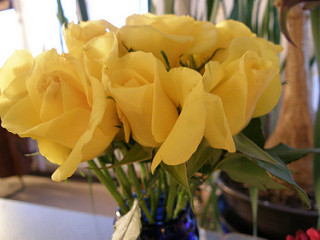

In [5]:
PIL.Image.open(str(roses[1]))

And some tulips:

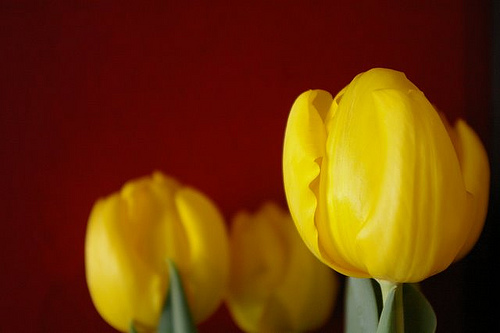

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

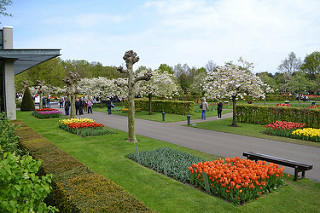

In [7]:
PIL.Image.open(str(tulips[1]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. 

### Create a dataset

Define some parameters for the loader:

In [8]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for testing.

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
                                          data_dir,
                                          validation_split=0.2,
                                          subset="training",
                                          seed=SEED,
                                          image_size=(IMG_HEIGHT, IMG_WIDTH),
                                          batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
                                          data_dir,
                                          validation_split=0.2,
                                          subset="validation",
                                          seed=SEED,
                                          image_size=(IMG_HEIGHT, IMG_WIDTH),
                                          batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

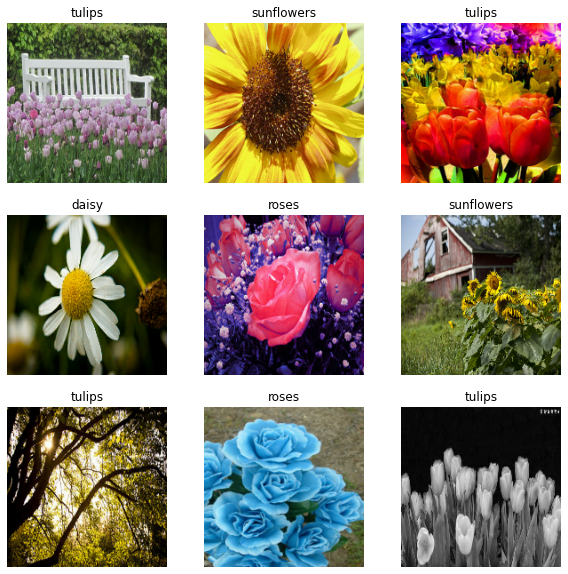

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [13]:
for image_batch, labels_batch in train_ds.take(1):
  print(f"Image batch size: {image_batch.shape}")
  print(f"Label batch size: {labels_batch.shape}")

Image batch size: (32, 180, 180, 3)
Label batch size: (32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance
These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will save some operations (like file opening and data reading) from being executed during each epoch.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training. While the model is executing training step `s`, the input pipeline is reading the data for step `s+1`. 

The number of elements to prefetch should be greater than or equal to the number of batches consumed by a single training step. You could either manually tune this value, or set it to `tf.data.AUTOTUNE`, which will prompt the `tf.data` runtime to tune the value dynamically at runtime.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
# Dataset optimizing transformations
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## A basic Keras model
---
***Task: 1***

Create a keras Sequential model consisting of three convolution blocks (`tf.keras.layers.Conv2D`) with filters `[16, 32, 64]` respectievly and a kernel size of 3x3, with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. Add a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). You may need to flatten the output before the dense layer.

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will first add a layer which standardize input values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

---

In [15]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [17]:
NUM_EPOCHS=10

training_info = model.fit(train_ds, validation_data=test_ds, epochs=NUM_EPOCHS)

Epoch 1/10
92/92 [==============================] - 18s 44ms/step - loss: 1.2833 - accuracy: 0.4700 - val_loss: 1.0773 - val_accuracy: 0.5695
Epoch 2/10
92/92 [==============================] - 2s 25ms/step - loss: 0.9521 - accuracy: 0.6294 - val_loss: 0.9293 - val_accuracy: 0.6471
Epoch 3/10
92/92 [==============================] - 2s 24ms/step - loss: 0.7348 - accuracy: 0.7272 - val_loss: 0.8910 - val_accuracy: 0.6526
Epoch 4/10
92/92 [==============================] - 2s 24ms/step - loss: 0.4903 - accuracy: 0.8202 - val_loss: 0.9814 - val_accuracy: 0.6471
Epoch 5/10
92/92 [==============================] - 2s 24ms/step - loss: 0.2968 - accuracy: 0.8992 - val_loss: 1.2239 - val_accuracy: 0.6104
Epoch 6/10
92/92 [==============================] - 2s 24ms/step - loss: 0.1662 - accuracy: 0.9441 - val_loss: 1.3551 - val_accuracy: 0.6294
Epoch 7/10
92/92 [==============================] - 2s 24ms/step - loss: 0.0750 - accuracy: 0.9782 - val_loss: 1.6115 - val_accuracy: 0.6390
Epoch 8/10
9

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

In [25]:
def create_loss_accuracy_plots(training_info):
  loss_history = training_info.history['loss']
  accuracy_history = training_info.history['accuracy']

  val_loss_history = training_info.history['val_loss']
  val_accuracy_history = training_info.history['val_accuracy']

  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
  axs[0].plot(range(1, NUM_EPOCHS+1), loss_history, label="train loss")
  axs[0].plot(range(1, NUM_EPOCHS+1), val_loss_history, label="val loss")
  axs[0].legend()
  axs[0].set_xlabel("Epochs")
  axs[0].set_ylabel("Loss")

  axs[1].plot(range(1, NUM_EPOCHS+1), accuracy_history, label="train accuracy")
  axs[1].plot(range(1, NUM_EPOCHS+1), val_accuracy_history, label="val accuracy")
  axs[1].legend()
  axs[1].set_xlabel("Epochs")
  axs[1].set_ylabel("Accuracy")

  plt.show()

create_loss_accuracy_plots(training_info)

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [20]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

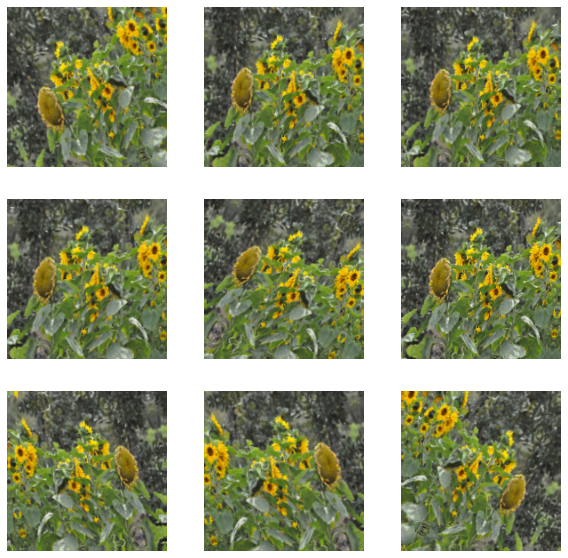

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce dropout regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

## Compile and train the model

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
training_info = model.fit(train_ds, validation_data=test_ds, epochs=NUM_EPOCHS)

Epoch 1/10
92/92 [==============================] - 5s 42ms/step - loss: 1.1827 - accuracy: 0.5123 - val_loss: 0.9843 - val_accuracy: 0.5926
Epoch 2/10
92/92 [==============================] - 4s 40ms/step - loss: 0.9825 - accuracy: 0.6066 - val_loss: 1.0061 - val_accuracy: 0.6349
Epoch 3/10
92/92 [==============================] - 4s 40ms/step - loss: 0.8986 - accuracy: 0.6543 - val_loss: 0.8887 - val_accuracy: 0.6744
Epoch 4/10
92/92 [==============================] - 4s 40ms/step - loss: 0.8192 - accuracy: 0.6853 - val_loss: 0.9454 - val_accuracy: 0.6540
Epoch 5/10
92/92 [==============================] - 4s 40ms/step - loss: 0.7522 - accuracy: 0.7170 - val_loss: 0.8032 - val_accuracy: 0.6798
Epoch 6/10
92/92 [==============================] - 4s 40ms/step - loss: 0.7034 - accuracy: 0.7207 - val_loss: 0.7887 - val_accuracy: 0.6921
Epoch 7/10
92/92 [==============================] - 4s 40ms/step - loss: 0.6919 - accuracy: 0.7415 - val_loss: 0.7637 - val_accuracy: 0.7221
Epoch 8/10
92

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

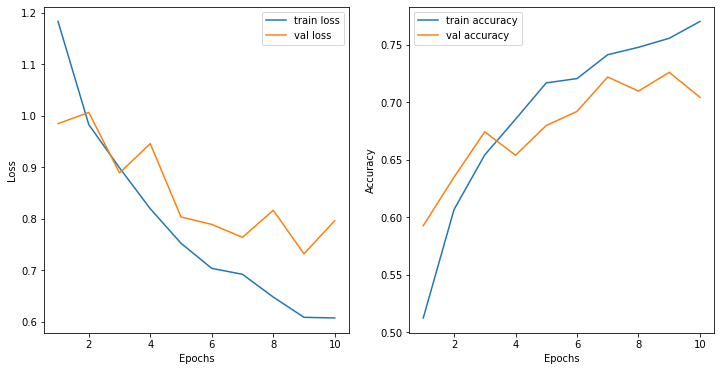

In [26]:
create_loss_accuracy_plots(training_info)